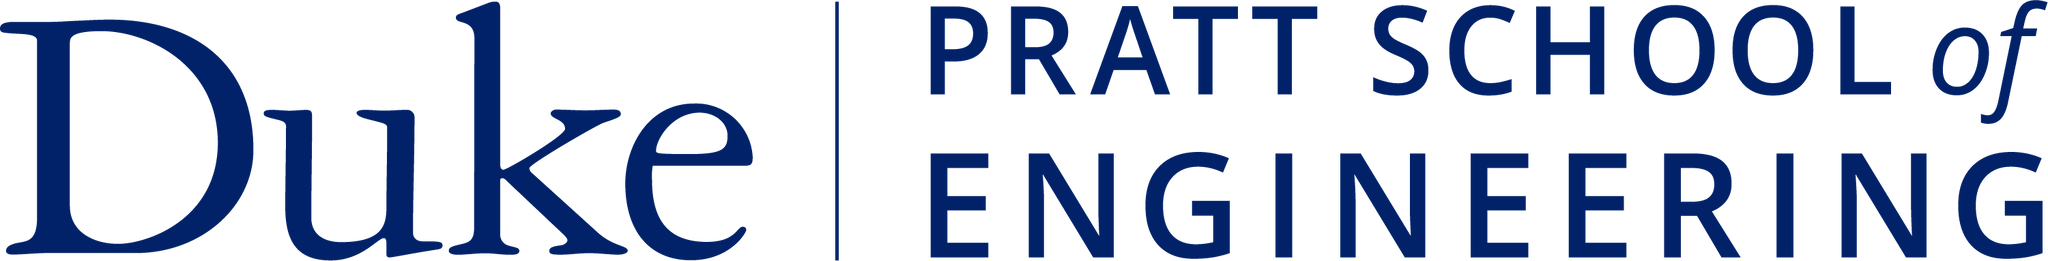

# FINTECH 545 Quantitative Risk Management
## Final Project

### Keese Phillips

[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/keesephillips/quantitative_risk_management/blob/main/Final_Project/notebook.ipynb)

In [ ]:
import os

# Remove Colab default sample_data
!rm -r ./sample_data

# Clone GitHub files to colab workspace
repo_name = "quantitative_risk_management"
git_path = 'https://github.com/keesephillips/quantitative_risk_management'
!git clone "{git_path}"

notebook_dir = 'Final_Project'

# Install dependencies from requirements.txt file
!pip install -r "{os.path.join(repo_name,notebook_dir,'requirements.txt')}"

# Change working directory to location of notebook
path_to_notebook = os.path.join(repo_name,notebook_dir)
%cd "{path_to_notebook}"
%ls

# Setup

In [2]:
import datetime
import math
import numpy as np
import statsmodels.api as sm
import pandas as pd
from scipy import stats
from scipy.integrate import quad 
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression

np.random.seed(42)

In [3]:
prices = pd.read_csv('DailyPrices.csv', index_col='Date', parse_dates=True, float_precision='high')
prices.head()

,SPY,AAPL,NVDA,MSFT,AMZN,META,GOOGL,AVGO,TSLA,GOOG,...,SBUX,MMC,MDT,CB,LMT,KKR,MU,PLD,LRCX,EQIX
Date,,,,,,,,,,,,,,,,,,,,,
2023-01-03,370.367920,123.768456,14.304595,236.183502,85.820000,124.265305,88.798103,53.397118,108.099998,89.378853,...,96.842888,161.264664,73.835571,214.210434,455.904877,45.874386,49.810677,106.143532,35.568180,639.647766
2023-01-04,373.227142,125.045052,14.738281,225.852097,85.139999,126.885315,87.761856,54.049290,113.639999,88.392403,...,100.329346,164.402908,76.392372,217.732574,454.921539,47.269882,53.598137,110.165482,36.268723,656.679016
2023-01-05,368.967438,123.718987,14.254632,219.158371,83.120003,126.456940,85.888649,53.545685,110.339996,86.459335,...,100.300537,161.420135,75.505508,216.917526,455.465698,46.581966,54.102486,106.294243,35.805130,637.822998
2023-01-06,377.428589,128.271118,14.848200,221.741211,86.080002,129.525223,87.024529,56.768929,113.059998,87.844360,...,102.471153,166.103210,76.288589,222.060059,451.809113,47.348503,56.139599,109.873489,38.226994,650.683350
2023-01-09,377.214661,128.795578,15.616640,223.900162,87.360001,128.977310,87.702065,55.655602,119.769997,88.482071,...,100.598274,165.549393,73.156288,216.869034,438.204468,48.783306,55.734154,109.317757,38.841690,657.654114


In [4]:
rf = pd.read_csv('rf.csv', index_col='Date', parse_dates=True)
rf.head()

,rf
Date,
2023-01-04,0.000150
2023-01-05,0.000250
2023-01-06,0.000100
2023-01-09,0.000000
2023-01-10,0.000349


In [5]:
def return_calculate(prices, method="ARITHMETIC", dateIndex=True, dateColumn="Date", remove_mean=False):
    if dateIndex:
        dates = prices.index[1:]
    else:
        if dateColumn not in prices.columns:
            raise ValueError(f"dateColumn '{dateColumn}' not found in DataFrame columns.")
        
        dates = prices[dateColumn].iloc[1:].reset_index(drop=True)

    
    price_columns = [col for col in prices.columns if col != dateColumn]
    current_prices = prices[price_columns]
    
    p_ratio = current_prices.shift(-1).iloc[:-1, :] / current_prices.iloc[:-1, :].values
    
    if method.upper() == "ARITHMETIC":
        returns = p_ratio - 1
    elif method.upper() == "LOG":
        returns = np.log(p_ratio)
        
    for col in returns.columns:
        if remove_mean:
            mean = returns[col].mean()
            returns[col] -= mean
    
    if dateIndex:
        out = pd.DataFrame(index=dates)
    else:
        out = pd.DataFrame({dateColumn: dates})
    
    for col in price_columns:
        out[col] = returns[col].values
    
    std_deviations = returns.iloc[:,:].std()
    
    return out, std_deviations


returns, _ = return_calculate(prices, method="ARITHMETIC", dateColumn="Date", remove_mean=False)    
returns.head()


,SPY,AAPL,NVDA,MSFT,AMZN,META,GOOGL,AVGO,TSLA,GOOG,...,SBUX,MMC,MDT,CB,LMT,KKR,MU,PLD,LRCX,EQIX
Date,,,,,,,,,,,,,,,,,,,,,
2023-01-04,0.007720,0.010314,0.030318,-0.043743,-0.007924,0.021084,-0.011670,0.012214,0.051249,-0.011037,...,0.036001,0.019460,0.034628,0.016442,-0.002157,0.030420,0.076037,0.037892,0.019696,0.026626
2023-01-05,-0.011413,-0.010605,-0.032816,-0.029638,-0.023726,-0.003376,-0.021344,-0.009318,-0.029039,-0.021869,...,-0.000287,-0.018143,-0.011609,-0.003743,0.001196,-0.014553,0.009410,-0.035140,-0.012782,-0.028714
2023-01-06,0.022932,0.036794,0.041640,0.011785,0.035611,0.024263,0.013225,0.060196,0.024651,0.016019,...,0.021641,0.029012,0.010371,0.023707,-0.008028,0.016456,0.037653,0.033673,0.067640,0.020163
2023-01-09,-0.000567,0.004089,0.051753,0.009736,0.014870,-0.004230,0.007786,-0.019612,0.059349,0.007260,...,-0.018277,-0.003334,-0.041059,-0.023377,-0.030111,0.030303,-0.007222,-0.005058,0.016080,0.010713
2023-01-10,0.007013,0.004456,0.017981,0.007617,0.028732,0.027188,0.004544,-0.003398,-0.007681,0.004955,...,0.012030,0.000000,0.017410,0.005637,0.007190,0.009871,0.015082,-0.000086,0.013660,0.020539


In [6]:
excess = returns.sub(rf['rf'], axis=0)
excess.head()

,SPY,AAPL,NVDA,MSFT,AMZN,META,GOOGL,AVGO,TSLA,GOOG,...,SBUX,MMC,MDT,CB,LMT,KKR,MU,PLD,LRCX,EQIX
Date,,,,,,,,,,,,,,,,,,,,,
2023-01-04,0.007570,0.010165,0.030168,-0.043893,-0.008073,0.020934,-0.011819,0.012064,0.051099,-0.011187,...,0.035851,0.019310,0.034479,0.016293,-0.002307,0.030270,0.075887,0.037742,0.019546,0.026476
2023-01-05,-0.011663,-0.010854,-0.033066,-0.029887,-0.023975,-0.003626,-0.021594,-0.009567,-0.029289,-0.022119,...,-0.000537,-0.018393,-0.011859,-0.003993,0.000946,-0.014803,0.009160,-0.035390,-0.013032,-0.028964
2023-01-06,0.022832,0.036694,0.041541,0.011685,0.035511,0.024164,0.013125,0.060096,0.024551,0.015920,...,0.021541,0.028912,0.010271,0.023607,-0.008128,0.016356,0.037553,0.033573,0.067540,0.020063
2023-01-09,-0.000567,0.004089,0.051753,0.009736,0.014870,-0.004230,0.007786,-0.019612,0.059349,0.007260,...,-0.018277,-0.003334,-0.041059,-0.023377,-0.030111,0.030303,-0.007222,-0.005058,0.016080,0.010713
2023-01-10,0.006663,0.004107,0.017631,0.007268,0.028382,0.026838,0.004195,-0.003747,-0.008031,0.004606,...,0.011680,-0.000349,0.017061,0.005288,0.006840,0.009522,0.014732,-0.000436,0.013310,0.020189


In [7]:
portfolios = pd.read_csv('initial_portfolio.csv')
total = portfolios.groupby(['Symbol'], as_index=False)['Holding'].sum()
total['Portfolio'] = 'Total'
portfolios = pd.concat([portfolios, total])
portfolios.tail()

,Portfolio,Symbol,Holding
94,Total,VRTX,25.0
95,Total,VZ,251.0
96,Total,WFC,142.0
97,Total,WMT,112.0
98,Total,XOM,94.0


In [8]:
portfolio_matrix = portfolios.pivot(index='Symbol', columns='Portfolio', values='Holding').fillna(0)
portfolio_matrix.head()

Portfolio,A,B,C,Total
Symbol,,,,
AAPL,0.0,42.0,0.0,42.0
ABBV,0.0,0.0,56.0,56.0
ABT,0.0,89.0,0.0,89.0
ACN,0.0,29.0,0.0,29.0
ADBE,0.0,24.0,0.0,24.0


# Part 1

In [ ]:
start_hold = pd.Timestamp('2024-01-02')
end_hold = prices.index.max()       

train_excess = excess.loc[excess.index < start_hold]
train_market = train_excess['SPY'] 
test_excess = excess.loc[excess.index > start_hold]       

initial_prices = prices.loc[start_hold]
final_prices = prices.loc[end_hold]

rf_period = rf.loc[start_hold:, 'rf']
rf_total_return = (1 + rf_period).prod() - 1

market_total_return = final_prices['SPY'] / initial_prices['SPY'] - 1
market_excess_return = market_total_return - rf_total_return
average_market_excess = train_market.mean()

In [10]:
def capm_regression(data, market_data, market_index='SPY'):
    capm_params = {}
    for ticker in data.columns:
        if ticker == market_index: 
            continue

        y = data[ticker]
        X = sm.add_constant(market_data)
        model = sm.OLS(y, X).fit()
        alpha = model.params['const']
        beta = model.params[market_index] 
        resid = model.resid.var()
        capm_params[ticker] = {'alpha': alpha, 'beta': beta, 'resid': resid}

    return capm_params

capm_params = capm_regression(train_excess, train_market)


In [11]:
def calculate_portfolio_weights(portfolios, prices, hold_date):
    prices_end2023 = prices[prices.index == pd.Timestamp(hold_date)].iloc[0] 

    port_values = {port: [] for port in portfolios['Portfolio'].unique()}
    port_totals = {}
    original_weights = {}

    for port in portfolios['Portfolio'].unique():
        for symbol, holding in zip(portfolios[portfolios['Portfolio'] == port]['Symbol'], portfolios[portfolios['Portfolio'] == port]['Holding']):
            price = prices_end2023[symbol]
            port_values[port].append(holding * price)

    for port in port_values:
        port_totals[port] = sum(port_values[port])

    for port in portfolios['Portfolio'].unique():
        original_weights[port] = {symbol: (holding * prices_end2023[symbol]) / port_totals[port] for symbol, holding in zip(portfolios[portfolios['Portfolio'] == port]['Symbol'], portfolios[portfolios['Portfolio'] == port]['Holding']) }

    return original_weights

original_weights = calculate_portfolio_weights(portfolios, prices, start_hold)

In [ ]:
def run_attribition(weights, symbols, port, capm_params, daily_excess_returns, market_symbol='SPY', annualization_factor=255, rf=rf_total_return):
    portfolio_weights = weights[port]
    if isinstance(portfolio_weights, dict):
        w_p = np.array([ weight for weight in portfolio_weights.values()]) 
    else:
        w_p = portfolio_weights
    
    portfolio_assets_daily_returns = daily_excess_returns[symbols]
    market_daily_excess = daily_excess_returns[market_symbol]

    portfolio_daily_excess = portfolio_assets_daily_returns.values @ w_p
    portfolio_daily_excess = pd.Series(portfolio_daily_excess, index=portfolio_assets_daily_returns.index)

    beta_p = sum(portfolio_weights[sym] * capm_params[sym]['beta'] for sym in symbols)

    total_portfolio_excess_return = (1 + portfolio_daily_excess).prod() - 1 
    total_market_excess_return = (1 + market_daily_excess).prod() - 1 

    systematic_return = beta_p * total_market_excess_return
    idiosyncratic_return = total_portfolio_excess_return - systematic_return 
    
    market_var = market_daily_excess.var() * annualization_factor
    market_vol = np.sqrt(market_var)

    portfolio_total_var = portfolio_daily_excess.var() * annualization_factor
    portfolio_total_vol = np.sqrt(portfolio_total_var)

    systematic_var = (beta_p**2) * market_var
    systematic_vol = np.sqrt(systematic_var)

    daily_residuals = portfolio_daily_excess - beta_p * market_daily_excess
    realized_idio_var = daily_residuals.var() * annualization_factor
    realized_idio_var = max(0, realized_idio_var)
    realized_idio_vol = np.sqrt(realized_idio_var)

    pred_idio_var_daily = sum((portfolio_weights[sym]**2) * capm_params[sym]['resid'] for sym in symbols)
    pred_idio_var = pred_idio_var_daily * annualization_factor
    pred_idio_vol = np.sqrt(pred_idio_var)

    valid_idx = portfolio_daily_excess.notna() & market_daily_excess.notna()

    portfolio_daily_excess_clean = portfolio_daily_excess[valid_idx]
    market_daily_excess_clean = market_daily_excess[valid_idx]

    syst_daily_ret_clean = beta_p * market_daily_excess_clean
    idio_daily_ret_clean = portfolio_daily_excess_clean - syst_daily_ret_clean 
    
    X_reg = portfolio_daily_excess_clean.values.reshape(-1, 1)
    Y_reg = pd.DataFrame({'syst': syst_daily_ret_clean, 'idio': idio_daily_ret_clean}).values

    reg = LinearRegression(fit_intercept=False).fit(X_reg, Y_reg)

    betas_risk_decomp = reg.coef_

    component_sys_vol = betas_risk_decomp[0, 0] * portfolio_total_vol
    component_idio_vol = betas_risk_decomp[1, 0] * portfolio_total_vol

    attribution = {
        'Portfolio Beta': beta_p,
        
        # Returns 
        'Total Period Excess Return %': total_portfolio_excess_return * 100,
        'Systematic Return %': systematic_return * 100,
        'Idiosyncratic Return %': idiosyncratic_return * 100, 
        'Risk Free %': rf_total_return * 100,
        
        # Risk Decomposition 
        'Total Portfolio Vol %': portfolio_total_vol * 100,
        'Systematic Vol %': systematic_vol * 100, # beta * market_vol
        'Realized Idiosyncratic Vol %': realized_idio_vol * 100, # std_dev(residuals)
        'Predicted Idiosyncratic Vol %': pred_idio_vol * 100, # sqrt(sum(w_i^2 * sigma_ei^2))
        
        # Risk Attribution 
        'Component Systematic Vol %': component_sys_vol * 100, # B_sys * total_portfolio_vol
        'Component Idiosyncratic Vol %': component_idio_vol * 100, # B_idio * total_portfolio_vol
    }

    return attribution

In [13]:
attribution = {}
for port in portfolios['Portfolio'].unique():
    symbols = portfolios[portfolios['Portfolio']== port]['Symbol'].unique()
    attribution[port] = run_attribition(original_weights, symbols, port, capm_params, test_excess, market_symbol='SPY', annualization_factor=255)

data = []
for port in portfolios['Portfolio'].unique():
    row = {}
    row['Portfolio'] = port
    for key, vals in attribution[port].items():
        row[key] = attribution[port][key]
    data.append(row)
    
df1 = pd.DataFrame(data)
df1.head()

,Portfolio,Portfolio Beta,Total Period Excess Return %,Systematic Return %,Idiosyncratic Return %,Risk Free %,Total Portfolio Vol %,Systematic Vol %,Realized Idiosyncratic Vol %,Predicted Idiosyncratic Vol %,Component Systematic Vol %,Component Idiosyncratic Vol %
0,A,0.959041,7.874842,19.666727,-11.791884,5.227718,11.297868,12.117795,5.867757,4.278479,10.655499,0.642370
1,B,0.914901,15.150340,18.761557,-3.611216,5.227718,10.932711,11.560068,5.857195,3.757153,10.032225,0.900486
2,C,0.966868,23.041758,19.827221,3.214538,5.227718,12.243802,12.216684,4.857763,3.850632,11.246533,0.997269
3,Total,0.946809,14.994702,19.415886,-4.421184,5.227718,10.948042,11.963238,4.371185,2.302339,11.156675,-0.208632


# Part 2

In [ ]:
def calculate_expected_returns(portfolios, capm_params, rf, train_market):
    avg_rf = rf.loc[rf.index <= start_hold, 'rf'].mean()    
    average_market_excess = train_market.mean()           
    expected_return = {
        sym: avg_rf + capm_params[sym]['beta'] * average_market_excess 
        for sym in portfolios['Symbol'].unique()
    }   
    return expected_return

capm_params_no_alpha = capm_regression(train_excess - train_excess.mean(), train_market)
expected_return = calculate_expected_returns(portfolios, capm_params_no_alpha, rf, train_market)

def calculate_optimal_weights(portfolios, train_excess, expected_return, rf):
    avg_rf = rf.loc[rf.index <= start_hold, 'rf'].mean() 
    opt_weights = {}
    for port in portfolios['Portfolio'].unique():
        symbols = portfolios[portfolios['Portfolio']== port]['Symbol'].unique()
        mu = np.array([expected_return[sym] for sym in symbols])       
        cov_matrix = train_excess[symbols].cov().values  
        
        def neg_sharpe(w, mu=expected_return, rf_rate=avg_rf):
            port_excess = np.dot(w, [mu[s] for s in symbols]) - rf_rate
            port_vol = np.sqrt(w @ cov_matrix @ w)
            return -port_excess / port_vol
        
        cons = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}
        bounds = [(0, 1)] * len(symbols)

        w0 = np.full(len(symbols), 1/len(symbols))
        result = minimize(neg_sharpe, w0, bounds=bounds, constraints=cons, tol=1e-9)
        opt_weights[port] = {sym: result.x[i] for i, sym in enumerate(symbols)}
    
    return opt_weights

opt_weights = calculate_optimal_weights(portfolios, train_excess, expected_return, rf)


attribution = {}
for port in portfolios['Portfolio'].unique():
    symbols = portfolios[portfolios['Portfolio']== port]['Symbol'].unique()
    attribution[port] = {
        'Original': run_attribition(original_weights, symbols, port, capm_params, test_excess, market_symbol='SPY', annualization_factor=255)
        ,
        'Optimal': run_attribition(opt_weights, symbols, port, capm_params, test_excess, market_symbol='SPY', annualization_factor=255)
    }

    
data = []
for port in portfolios['Portfolio'].unique():
    for port_type, port_vals in attribution[port].items():
        row = {}
        row['Portfolio'] = f'{port} {port_type}'
        for key, vals in attribution[port][port_type].items():
            row[key] = attribution[port][port_type][key]
        data.append(row)
    
df2 = pd.DataFrame(data)
df2.head(10)

,Portfolio,Portfolio Beta,Total Period Excess Return %,Systematic Return %,Idiosyncratic Return %,Risk Free %,Total Portfolio Vol %,Systematic Vol %,Realized Idiosyncratic Vol %,Predicted Idiosyncratic Vol %,Component Systematic Vol %,Component Idiosyncratic Vol %
0,A Original,0.959041,7.874842,19.666727,-11.791884,5.227718,11.297868,12.117795,5.867757,4.278479,10.655499,0.642370
1,A Optimal,1.013826,20.289414,20.790188,-0.500775,5.227718,11.699512,12.810024,4.596329,4.933395,11.960745,-0.261233
2,B Original,0.914901,15.150340,18.761557,-3.611216,5.227718,10.932711,11.560068,5.857195,3.757153,10.032225,0.900486
3,B Optimal,1.011493,21.094920,20.742345,0.352575,5.227718,11.699235,12.780545,4.708023,4.076027,11.880110,-0.180875
4,C Original,0.966868,23.041758,19.827221,3.214538,5.227718,12.243802,12.216684,4.857763,3.850632,11.246533,0.997269
5,C Optimal,1.018251,25.360750,20.880917,4.479833,5.227718,12.749928,12.865927,4.752671,4.473697,11.964720,0.785208
6,Total Original,0.946809,14.994702,19.415886,-4.421184,5.227718,10.948042,11.963238,4.371185,2.302339,11.156675,-0.208632
7,Total Optimal,1.000123,20.781178,20.509169,0.272009,5.227718,11.389648,12.636872,3.122710,3.149573,12.266246,-0.876598


# Part 4

In [15]:
def VaR_array(a, alpha=0.05):
    x = np.sort(a)
    nup = int(np.ceil(len(a) * alpha))
    ndn = int(np.floor(len(a) * alpha))
    v = 0.5 * (x[nup-1] + x[ndn-1]) 
    
    return -v

def ES_array(a, alpha=0.05):
    x = np.sort(a)
    nup = int(np.ceil(len(a) * alpha))
    ndn = int(np.floor(len(a) * alpha))
    v = 0.5 * (x[nup-1] + x[ndn-1])  
    
    es = np.mean(x[x <= v])
    return -es

def VaR_dist(d, alpha=0.05):
    return -d.ppf(alpha)

def ES_dist(d, alpha=0.05):
    v = VaR_dist(d, alpha=alpha)
    
    def f(x):
        return x * d.pdf(x)
    
    st = d.ppf(1e-12)
    result, _ = quad(f, st, -v)
    
    return -result / alpha

def near_psd(a, epsilon=1e-6): 
    n = a.shape[0]
    invSD = None
    out = a.copy()

    # Calculate the correlation matrix if covariance
    if not np.allclose(np.diag(out), 1.0):
        diag_std = np.sqrt(np.diag(out))
        diag_std[diag_std == 0] = 1e-12 
        invSD = np.diag(1.0 / diag_std)
        out = invSD @ out @ invSD

    eigval, eigvec = np.linalg.eigh(out) 
    clipped_eigval = np.maximum(eigval, epsilon)
    out = eigvec @ np.diag(clipped_eigval) @ eigvec.T

    # Rescale back to covariance matrix if necessary
    if invSD is not None:
        SD = np.diag(1.0 / np.diag(invSD))
        out = SD @ out @ SD

    out = (out + out.T) / 2
    return out


best_dist_details = {} 
for sym in portfolios['Symbol'].unique():
    if sym == 'SPY': 
        continue 
        
    data = train_excess[sym].values
        
    fits = {}
    AICs = {}
    
    # Fit Normal
    loc_norm, scale_norm = stats.norm.fit(data)
    logL_norm = np.sum(stats.norm.logpdf(data, loc=loc_norm, scale=scale_norm))
    AIC_norm = -2*logL_norm + 2*2 
    fits['Normal'] = (loc_norm, scale_norm)
    AICs['Normal'] = AIC_norm

    # Fit Student's t (Generalized T)
    df_t, loc_t, scale_t = stats.t.fit(data) 
    logL_t = np.sum(stats.t.logpdf(data, df=df_t, loc=loc_t, scale=scale_t))
    AIC_t = -2*logL_t + 2*3  
    fits['StudentT'] = (df_t, loc_t, scale_t)
    AICs['StudentT'] = AIC_t

    # Fit Skew Normal
    a_sn, loc_sn, scale_sn = stats.skewnorm.fit(data)
    logL_sn = np.sum(stats.skewnorm.logpdf(data, a=a_sn, loc=loc_sn, scale=scale_sn))
    AIC_sn = -2*logL_sn + 2*3  
    fits['SkewNorm'] = (a_sn, loc_sn, scale_sn)
    AICs['SkewNorm'] = AIC_sn

    #Fit NIG
    a_nig, b_nig, loc_nig, scale_nig = stats.norminvgauss.fit(data) 
    logL_nig = np.sum(stats.norminvgauss.logpdf(data, a=a_nig, b=b_nig, loc=loc_nig, scale=scale_nig))
    AIC_nig = -2*logL_nig + 2*4  
    fits['NIG'] = (a_nig, b_nig, loc_nig, scale_nig)
    AICs['NIG'] = AIC_nig


    best_dist_name = min(AICs, key=AICs.get)
    best_params = fits[best_dist_name]
    best_dist_details[sym] = {'name': best_dist_name, 'params': best_params, 'aic': AICs[best_dist_name]}


frozen_dists_zero_mean = {}
for sym, details in best_dist_details.items():
    dist_name = details['name']
    params = details['params']
    if dist_name == 'Normal':
        _loc, scale = params
        frozen_dists_zero_mean[sym] = stats.norm(loc=0, scale=scale)
    elif dist_name == 'StudentT':
        df, _loc, scale = params
        frozen_dists_zero_mean[sym] = stats.t(df, loc=0, scale=scale)
    elif dist_name == 'SkewNorm':
        a, _loc, scale = params
        delta = a / np.sqrt(1 + a**2)
        mean_offset = scale * delta * np.sqrt(2 / np.pi)
        frozen_dists_zero_mean[sym] = stats.skewnorm(a, loc=-mean_offset, scale=scale) 
    elif dist_name == 'NIG':
        a, b, _loc, scale = params
        gamma = np.sqrt(a**2 - b**2)
        mean_offset = scale * b / gamma
        frozen_dists_zero_mean[sym] = stats.norminvgauss(a, b, loc=-mean_offset, scale=scale)



print("1-Day 95% VaR and ES (Gaussian Copula):")
valid_symbols_copula = list(frozen_dists_zero_mean.keys()) 
corr_matrix_copula = train_excess[valid_symbols_copula].rank().corr(method='spearman').values
corr_matrix_copula = near_psd(corr_matrix_copula) 

NSim = 1000

mean_vec = np.zeros(len(valid_symbols_copula))
sim_norm = stats.multivariate_normal.rvs(mean=mean_vec, cov=corr_matrix_copula, size=NSim)

U_sim = stats.norm.cdf(sim_norm)
U_sim = np.clip(U_sim, 1e-8, 1 - 1e-8)

simulated_returns_assets = pd.DataFrame(index=range(NSim), columns=valid_symbols_copula)
for i, sym in enumerate(valid_symbols_copula):
        simulated_returns_assets[sym] = frozen_dists_zero_mean[sym].ppf(U_sim[:, i])
        
risk_metrics_copula = {}
for port in original_weights.keys():
    port_syms = [s for s in portfolios[portfolios['Portfolio'] == port]['Symbol'] if s in valid_symbols_copula]
        
    port_w = np.array([original_weights[port][s] for s in port_syms])
    
    sim_asset_returns_portfolio = simulated_returns_assets[port_syms].values
    sim_portfolio_returns = sim_asset_returns_portfolio @ port_w
    
    var_copula = VaR_array(sim_portfolio_returns, alpha=0.05)
    es_copula = ES_array(sim_portfolio_returns, alpha=0.05)
    risk_metrics_copula[port] = {'VaR': var_copula, 'ES': es_copula}
    print(f"{port}: VaR={var_copula*100:.2f}%, ES={es_copula*100:.2f}%")


print("\n")
print("1-Day 95% VaR and ES (Multivariate Normal):")
cov_matrix_mvn = train_excess.cov().values
cov_matrix_mvn = near_psd(cov_matrix_mvn) 

risk_metrics_mvn = {}
alpha = 0.05
z_score = stats.norm.ppf(1 - alpha) 
pdf_z = stats.norm.pdf(z_score)

symbol_to_index = {sym: i for i, sym in enumerate(list(portfolios['Symbol'].unique()))}

for port in original_weights.keys():
    port_syms = portfolios[portfolios['Portfolio'] == port]['Symbol'] 
    port_indices = [symbol_to_index[s] for s in port_syms if s in symbol_to_index]
         
    port_w_list = [original_weights[port][s] for s in port_syms if s in symbol_to_index]
    port_w = np.array(port_w_list)
    
    port_cov = cov_matrix_mvn[np.ix_(port_indices, port_indices)]

    port_var_daily = port_w @ port_cov @ port_w

    port_std_daily = np.sqrt(port_var_daily)
    
    var_norm = port_std_daily * z_score 
    es_norm = port_std_daily * pdf_z / alpha
        
    risk_metrics_mvn[port] = {'VaR': var_norm, 'ES': es_norm}
    print(f"{port}: VaR={var_norm*100:.2f}%, ES={es_norm*100:.2f}%")
        


1-Day 95% VaR and ES (Gaussian Copula):
A: VaR=1.61%, ES=2.21%
B: VaR=1.44%, ES=1.94%
C: VaR=1.61%, ES=2.01%
Total: VaR=1.51%, ES=2.00%


1-Day 95% VaR and ES (Multivariate Normal):
A: VaR=1.36%, ES=1.70%
B: VaR=1.50%, ES=1.88%
C: VaR=1.43%, ES=1.79%
Total: VaR=1.37%, ES=1.72%


# Part 5

In [16]:
def simulate_returns(symbols, n_sim=10000):
    train_data = train_excess[symbols]
    spearman_corr = train_data.rank().corr(method='spearman').values
    spearman_corr_psd = near_psd(spearman_corr)
    
    mean = np.zeros(len(symbols))
    mvn_samples = stats.multivariate_normal.rvs(mean=mean, cov=spearman_corr_psd, size=n_sim)
    
    U = stats.norm.cdf(mvn_samples)
    U = np.clip(U, 1e-8, 1 - 1e-8)
    
    simulated_returns = pd.DataFrame(np.zeros((n_sim, len(symbols))), columns=symbols)
    for i, sym in enumerate(symbols):
        dist = frozen_dists_zero_mean[sym]
        simulated_returns.iloc[:, i] = dist.ppf(U[:, i])
    
    return simulated_returns

def compute_component_losses(weights, simulated_returns, alpha=0.05):
    portfolio_returns = simulated_returns.dot(weights)
    var = np.percentile(portfolio_returns, alpha * 100)
    tail_mask = portfolio_returns <= var
    if np.sum(tail_mask) == 0:
        return np.zeros(len(weights))
    component_losses = []
    for i in range(len(weights)):
        asset_returns = simulated_returns.iloc[:, i]
        mean_ri_tail = asset_returns[tail_mask].mean()
        component_loss = -weights[i] * mean_ri_tail
        component_losses.append(component_loss)
    return np.array(component_losses)

def objective_function(weights, simulated_returns, alpha=0.05):
    component_losses = compute_component_losses(weights, simulated_returns, alpha)
    if len(component_losses) == 0:
        return 0
    target = np.mean(component_losses)
    variance = np.sum((component_losses - target)**2)
    return variance

risk_parity_weights = {}
for port in portfolios['Portfolio'].unique():
    symbols = portfolios[portfolios['Portfolio'] == port]['Symbol']
    simulated_returns = simulate_returns(symbols, n_sim=100)
    n_assets = len(symbols)
    initial_weights = np.ones(n_assets) / n_assets
    bounds = [(0, 1)] * n_assets
    constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}]
    
    result = minimize(
        lambda w: objective_function(w, simulated_returns, 0.05),
        initial_weights,
        method='SLSQP',
        bounds=bounds,
        constraints=constraints,
        options={'maxiter': 5000, 'ftol': 1e-9}
    )
    
    optimal_weights = result.x
    risk_parity_weights[port] = {sym: optimal_weights[i] for i, sym in enumerate(symbols)}

attribution = {}
for port in risk_parity_weights.keys():
    symbols = portfolios[portfolios['Portfolio'] == port]['Symbol'].tolist()
    attribution[port] = run_attribition(risk_parity_weights, symbols, port, capm_params, test_excess, market_symbol='SPY')

data = []
for port in risk_parity_weights.keys():
    row = {'Portfolio': f'{port} Risk Parity'}
    for key, val in attribution[port].items():
        row[key] = val
    data.append(row)

df5 = pd.DataFrame(data)
df5 = pd.concat([df2, df5]).sort_values(by=['Portfolio'], ascending=True)
df5.head(15)

,Portfolio,Portfolio Beta,Total Period Excess Return %,Systematic Return %,Idiosyncratic Return %,Risk Free %,Total Portfolio Vol %,Systematic Vol %,Realized Idiosyncratic Vol %,Predicted Idiosyncratic Vol %,Component Systematic Vol %,Component Idiosyncratic Vol %
1,A Optimal,1.013826,20.289414,20.790188,-0.500775,5.227718,11.699512,12.810024,4.596329,4.933395,11.960745,-0.261233
0,A Original,0.959041,7.874842,19.666727,-11.791884,5.227718,11.297868,12.117795,5.867757,4.278479,10.655499,0.642370
0,A Risk Parity,0.907188,11.196286,18.603387,-7.407100,5.227718,10.663212,11.462610,5.671889,3.918075,10.014073,0.649139
3,B Optimal,1.011493,21.094920,20.742345,0.352575,5.227718,11.699235,12.780545,4.708023,4.076027,11.880110,-0.180875
2,B Original,0.914901,15.150340,18.761557,-3.611216,5.227718,10.932711,11.560068,5.857195,3.757153,10.032225,0.900486
1,B Risk Parity,0.870281,19.390555,17.846553,1.544002,5.227718,10.450466,10.996282,5.930315,3.703167,9.332187,1.118279
5,C Optimal,1.018251,25.360750,20.880917,4.479833,5.227718,12.749928,12.865927,4.752671,4.473697,11.964720,0.785208
4,C Original,0.966868,23.041758,19.827221,3.214538,5.227718,12.243802,12.216684,4.857763,3.850632,11.246533,0.997269
2,C Risk Parity,0.981250,26.761684,20.122155,6.639529,5.227718,12.576385,12.398411,4.636676,3.830306,11.518758,1.057627
7,Total Optimal,1.000123,20.781178,20.509169,0.272009,5.227718,11.389648,12.636872,3.122710,3.149573,12.266246,-0.876598
